In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

In [50]:
# Load the cleaned data from EDA
file = Path('clean_data_after_eda.csv')
df = pd.read_csv(file)

print("INITIAL DATA EXPLORATION")
print(f"\nShape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"\nTarget variable distribution:")
print(df['churn'].value_counts())
print(f"\nChurn rate: {df['churn'].mean() * 100:.2f}%")

INITIAL DATA EXPLORATION

Shape: (14606, 44)
Columns: 44

Target variable distribution:
churn
0    13187
1     1419
Name: count, dtype: int64

Churn rate: 9.72%


In [51]:

df_fe = df.drop(columns=['id'])
print(f"New shape: {df_fe.shape}")

New shape: (14606, 43)


In [52]:

date_columns = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

for col in date_columns:
    df_fe[col] = pd.to_datetime(df_fe[col], errors='coerce')

# Extract month from each date
df_fe['month_activ'] = df_fe['date_activ'].dt.month
df_fe['month_end'] = df_fe['date_end'].dt.month
df_fe['month_modif_prod'] = df_fe['date_modif_prod'].dt.month
df_fe['month_renewal'] = df_fe['date_renewal'].dt.month

# temporal features
reference_date = pd.to_datetime('2016-01-01')

# How long have they been a customer?
df_fe['tenure_days'] = (reference_date - df_fe['date_activ']).dt.days

# How many days until contract ends?
df_fe['days_to_end'] = (df_fe['date_end'] - reference_date).dt.days

# How long since they last modified their product?
df_fe['days_since_modif'] = (reference_date - df_fe['date_modif_prod']).dt.days

In [53]:

# Price difference columns for different periods
price_year_cols = ['var_year_price_off_peak', 'var_year_price_peak', 'var_year_price_mid_peak']
price_6m_cols = ['var_6m_price_off_peak', 'var_6m_price_peak', 'var_6m_price_mid_peak']

# Feature1: Average price change (overall trend)
df_fe['avg_price_change_year'] = df_fe[price_year_cols].mean(axis=1)
df_fe['avg_price_change_6m'] = df_fe[price_6m_cols].mean(axis=1)

# Feature 2: Maximum price change 

df_fe['max_price_change_year'] = df_fe[price_year_cols].max(axis=1)
df_fe['max_price_change_6m'] = df_fe[price_6m_cols].max(axis=1)

# Feature 3: Minimum price change
df_fe['min_price_change_year'] = df_fe[price_year_cols].min(axis=1)
df_fe['min_price_change_6m'] = df_fe[price_6m_cols].min(axis=1)

# Feature 4: Price variance
df_fe['price_variance_year'] = df_fe[price_year_cols].std(axis=1)
df_fe['price_variance_6m'] = df_fe[price_6m_cols].std(axis=1)



In [54]:
# Consumption trend: Is usage increasing or decreasing?
df_fe['cons_change_rate'] = (df_fe['cons_last_month'] * 12) / (df_fe['cons_12m'] + 1)

# Forecast accuracy: Does our forecast match reality?
df_fe['forecast_vs_actual_cons'] = df_fe['forecast_cons_12m'] / (df_fe['cons_12m'] + 1)

# Profitability per unit: Are they profitable customers?
df_fe['margin_per_kwh'] = df_fe['net_margin'] / (df_fe['cons_12m'] + 1)

# Margin difference: Gap between gross and net
df_fe['gross_net_margin_diff'] = df_fe['margin_gross_pow_ele'] - df_fe['margin_net_pow_ele']

df_fe.shape
df_fe.columns

Index(['channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max',
       'var_year_price_off_peak_var', 'var_year_price_peak_var',
       'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix',
       'var_year_price_peak_fix', 'var_year_price_mid_peak_fix',
       'var_year_price_off_peak', 'var_year_price_peak',
       'var_year_price_mid_peak', 'var_6m_price_off_peak_var',
       'var_6m_price_peak_var', 'var_6m_price_mid_peak_var',
       'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix',
       'var_6m_price_mid_peak_fix', 'var_6m_price_o

In [55]:
# Boolean to binary
df_fe['has_gas'] = df_fe['has_gas'].map({'t': 1, 'f': 0})

# Create dummy variables for categorical columns


for col in categorical_cols:
    n_categories = df_fe[col].nunique()

In [56]:

# Columns identified as highly skewed in EDA
skewed_columns = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'pow_max', 'forecast_cons_12m', 'forecast_cons_year']

for col in skewed_columns:
    if col in df_fe.columns:
        # Measure skewness before
        skew_before = df_fe[col].skew()
        
        # Apply log(1 + x) transformation (log1p handles zeros)
        df_fe[f'{col}_log'] = np.log1p(df_fe[col])
        
        # Measure skewness after
        skew_after = df_fe[f'{col}_log'].skew()
        
        improvement = abs(skew_before) - abs(skew_after)
        print(f"  {col:25} | Before: {skew_before:6.2f} | After: {skew_after:6.2f} | Δ {improvement:5.2f}")

  cons_12m                  | Before:   6.00 | After:  -0.38 | Δ  5.62
  cons_gas_12m              | Before:   9.60 | After:   1.88 | Δ  7.72
  cons_last_month           | Before:   6.39 | After:  -0.19 | Δ  6.20
  pow_max                   | Before:   5.79 | After:   1.80 | Δ  3.98
  forecast_cons_12m         | Before:   7.16 | After:  -2.03 | Δ  5.12
  forecast_cons_year        | Before:  16.59 | After:  -0.12 | Δ 16.47


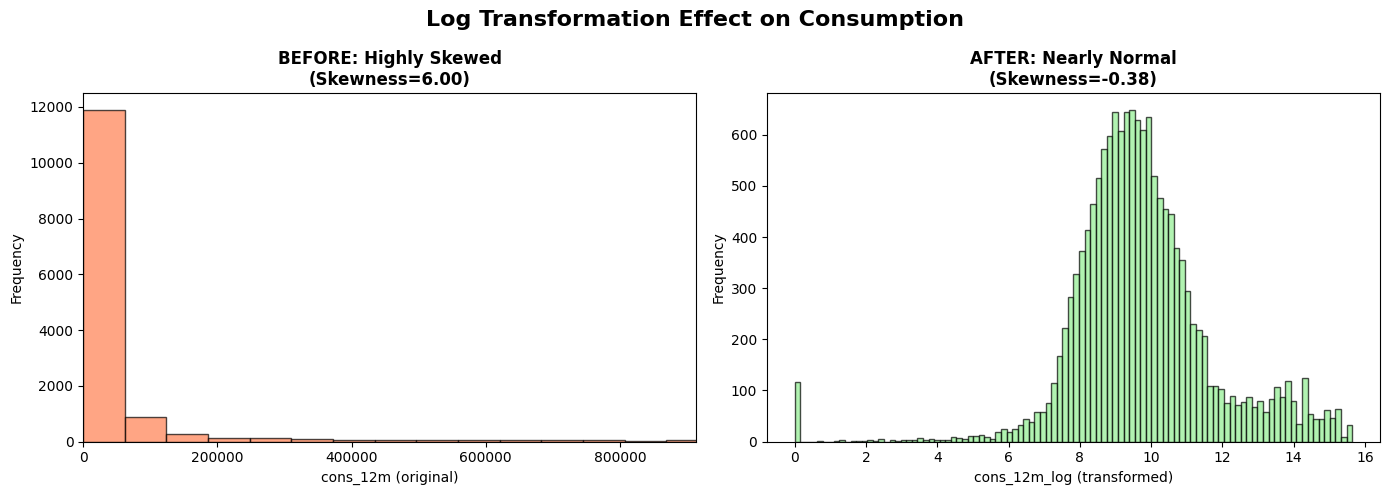

In [57]:
# Create before/after comparison for cons_12m
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before transformation
axes[0].hist(df['cons_12m'], bins=100, color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('cons_12m (original)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'BEFORE: Highly Skewed\n(Skewness={df["cons_12m"].skew():.2f})', fontweight='bold')
axes[0].set_xlim(0, np.percentile(df['cons_12m'], 95))

# After transformation
axes[1].hist(df_fe['cons_12m_log'], bins=100, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('cons_12m_log (transformed)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'AFTER: Nearly Normal\n(Skewness={df_fe["cons_12m_log"].skew():.2f})', fontweight='bold')

plt.suptitle('Log Transformation Effect on Consumption', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [58]:

# Get numeric columns
numeric_columns = df_fe.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
correlation_matrix = df_fe[numeric_columns].corr().abs()

# Find highly correlated pairs (correlation > 0.95)
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Identify features to drop
high_corr_pairs = []
for column in upper_triangle.columns:
    correlated_features = upper_triangle[column][upper_triangle[column] > 0.95].index.tolist()
    if correlated_features:
        for feature in correlated_features:
            high_corr_pairs.append((column, feature, upper_triangle.loc[feature, column]))

print(f"\nFound {len(high_corr_pairs)} pairs with correlation > 0.95\n")


# Remove one feature from each correlated pair
features_to_drop = set()
for feat1, feat2, corr in high_corr_pairs:
    # Keep first feature, drop second (arbitrary but consistent)
    if feat2 not in features_to_drop and feat2 != 'churn':
        features_to_drop.add(feat2)

if features_to_drop:
    df_fe = df_fe.drop(columns=list(features_to_drop))

print(f"\nFinal shape: {df_fe.shape}")


Found 30 pairs with correlation > 0.95


Final shape: (14606, 50)
